<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/cnn_cifar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CNN for image classification using PyTorch

In this section, we follow Chap. 8 of the [Deep Learning With PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf) book, and illustrate how to fit a CNN to a two-class version of CIFAR. We modify the code from [here](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch8/1_convolution.ipynb)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from functools import partial
import os
import collections



In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print("current device {}".format(torch.cuda.current_device()))
else:
  print("Torch cannot find GPU")

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


torch version 1.8.0+cu101
Tesla P100-PCIE-16GB
current device 0


# Get the data

We standardize the data. (The mean/std of the RGB channels are precomputed in the MLP version of this colab.)


In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = 'data'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['plane', 'bird']
nclasses = 2
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

# Basics of convolution

Lets apply a set of `nfeatures` convolutional kernels to a gray scale image.

In [6]:
img, label = cifar2[0]
img_batch  = img.unsqueeze(0)
print(img_batch.shape)

nfeatures = 16
kernel_size = 3
conv = nn.Conv2d(3, nfeatures, kernel_size=kernel_size) 
output = conv(img_batch)
print(output.shape)


torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 30, 30])


Now we adding padding to ensure output size is same as input.

In [7]:
nfeatures = 16
kernel_size = 3
pad = kernel_size // 2
conv = nn.Conv2d(3, nfeatures, kernel_size=kernel_size, padding=pad) 

output = conv(img_batch)
print(output.shape)

torch.Size([1, 16, 32, 32])


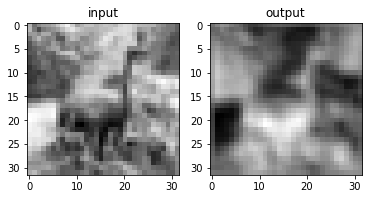

In [8]:
def show_results(img_batch, output_batch, index=0, channel=0):
  ax1 = plt.subplot(1, 2, 1)  
  img = img_batch[index] 
  plt.imshow(img.mean(0), cmap='gray')  
  plt.title('input')   
  plt.subplot(1, 2, 2) #, sharex=ax1, sharey=ax1) 
  plt.title('output')   
  out = output_batch[index, channel]
  plt.imshow(out.detach(), cmap='gray')
  plt.show()

show_results(img_batch, output)

Currently the filter parameters are random.

In [9]:
print(conv)
print(conv.weight.shape) # nfeatures x nchannels x kernel x kernel
print(conv.bias.shape) # nfeatures 
print(conv.weight[0,:,:,:])

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([16, 3, 3, 3])
torch.Size([16])
tensor([[[-0.1274,  0.0786, -0.0512],
         [ 0.1676, -0.0029, -0.0902],
         [-0.1278, -0.1626, -0.1557]],

        [[-0.1600, -0.1405, -0.1750],
         [-0.1328, -0.0750,  0.0389],
         [-0.0785, -0.1552, -0.0628]],

        [[-0.1040, -0.0039,  0.0932],
         [-0.1684, -0.1494, -0.0493],
         [-0.1345,  0.0108, -0.0021]]], grad_fn=<SliceBackward>)


Let's make the first filter just be an averaging operation.

tensor([[[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]]], grad_fn=<SliceBackward>)


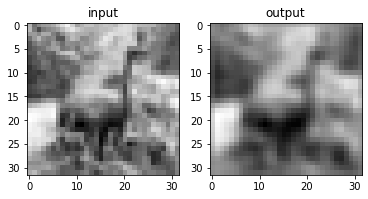

In [10]:

with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
print(conv.weight[0,:,:,:])

output_batch = conv(img_batch)
show_results(img_batch, output_batch)

Let's make the first filter be a vertical edge detector.

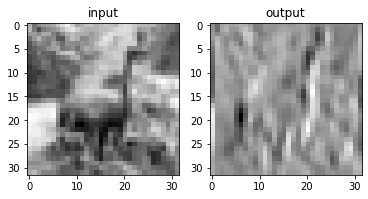

In [11]:

conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output_batch = conv(img_batch)
show_results(img_batch, output_batch)

# Max-pooling

We can reduce the size of the internal feature maps by using max-pooling.

torch.Size([1, 3, 16, 16])


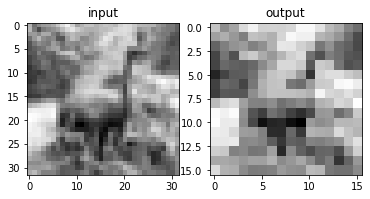

In [12]:
pool = nn.MaxPool2d(2)
output_batch = pool(img_batch)
print(output_batch.shape)

show_results(img_batch, output_batch)

# Making our first CNN

In [13]:
import torch.nn.functional as F

nchannels, nrows, ncols = img.shape

class Net(nn.Module):
    def __init__(self, nclasses, img):
        super().__init__()
        nchannels, nrows, ncols = img.shape
        self.conv1 = nn.Conv2d(nchannels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        # size of input to fc1 will be  8 * nrows/4 * ncols/4, 
        # since we will apply 2 maxpooling layers with size 2
        self.nflat = nrows//4 * ncols//4
        self.fc1 = nn.Linear(8 * self.nflat, 32)
        self.fc2 = nn.Linear(32, nclasses)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * self.nflat)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net(nclasses, img_batch[0])
out_batch = model(img_batch)
print(out_batch.shape)


torch.Size([1, 2])


# Training loop

In [14]:
import datetime  

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader: 
            outputs = model(imgs)  
            loss = loss_fn(outputs, labels) 
            optimizer.zero_grad()  
            loss.backward()  
            optimizer.step() 
            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  

In [16]:

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  

model = Net(nclasses, img_batch[0])
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss() 

training_loop(  
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-03-24 05:03:39.686066 Epoch 1, Training loss 0.5801711991714065
2021-03-24 05:04:08.229516 Epoch 10, Training loss 0.32593086266973215
2021-03-24 05:04:39.827068 Epoch 20, Training loss 0.29120124212116194
2021-03-24 05:05:11.203607 Epoch 30, Training loss 0.2692907575494165
2021-03-24 05:05:42.868199 Epoch 40, Training loss 0.24836591987093543
2021-03-24 05:06:14.297978 Epoch 50, Training loss 0.2304051037237143
2021-03-24 05:06:46.874412 Epoch 60, Training loss 0.21587384781640045
2021-03-24 05:07:17.989566 Epoch 70, Training loss 0.19915552916610316
2021-03-24 05:07:48.988302 Epoch 80, Training loss 0.18369974691871624
2021-03-24 05:08:20.043541 Epoch 90, Training loss 0.1668714184527564
2021-03-24 05:08:50.908946 Epoch 100, Training loss 0.152507900812064


# Validation accuracy

In [17]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def accuracy(model, loader):
  correct = 0
  total = 0
  with torch.no_grad(): 
      for imgs, labels in loader:
          outputs = model(imgs)
          _, predicted = torch.max(outputs, dim=1) 
          total += labels.shape[0]  # batch size
          correct += int((predicted == labels).sum())  
  accuracy =  correct / total
  return accuracy


train_acc = accuracy(model, train_loader)
val_acc = accuracy(model, val_loader)
print([train_acc, val_acc])

[0.9338, 0.8895]


In [33]:
dataiter = iter(train_loader)
img_batch, label_batch = dataiter.next()
print(img_batch.shape)

outputs = model(img_batch)
_, predicted = torch.max(outputs, dim=1) 


torch.Size([64, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


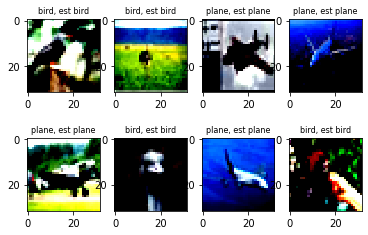

In [42]:
def imshow(img, ax):
  #img = img / 2 + 0.5     # unnormalize from -1..1 to 0..1
  npimg = img.numpy()
  ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def plot_results(images, labels, pred_labels, nrows, ncols):
  fig, axs = plt.subplots(nrows, ncols) 
  k = 0
  for i in range(nrows):
    for j in range(ncols):
      ax = axs[i,j]
      imshow(images[k], ax)
      ttl = f'{class_names[labels[k]]}, est {class_names[pred_labels[k]]}'
      ax.set_title(ttl, fontsize=8)
      k += 1

plot_results(img_batch, label_batch, predicted, 2,4)

torch.Size([3, 768, 1024])


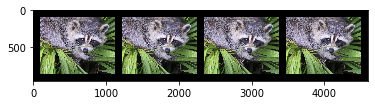

In [23]:


import scipy.misc
lena = scipy.misc.face()
img = transforms.ToTensor()(lena)
print(img.size())
imglist = [img, img, img, img]
show(torchvision.utils.make_grid(imglist, padding=100))

# Save/load model

In [18]:
out = model(img_batch)
fname = os.path.join(data_path, 'birds_vs_airplanes.pt')
torch.save(model.state_dict(), fname)



loaded_model = Net(nclasses, img_batch[0])
loaded_model.load_state_dict(torch.load(fname))
out2 = loaded_model(img_batch)
torch.testing.assert_allclose(out, out2)
